# MovieLens
Movie Lens is a website that helps users find the movies they like and where they will rate the recommended movies. [MovieLens 1M dataset](https://grouplens.org/datasets/movielens/1m/) is a dataset including the observations collected in an online movie recommendation experiment and is widely used to generate data for online bandit simulation studies. The goal of the simulation studies below is to learn the reward distribution of different movie genres and hence to recommend the optimal movie genres to the users to optimize the cumulative user satisfaction. In other words, every time a user visits the website, the agent will recommend a movie genre ($A_t$) to the user, and then the user will give a rating ($R_t$) to the genre recommended. We assume that users' satisfaction is fully reflected through the ratings. Therefore, the ultimate goal of the bandit algorithms is to optimize the cumulative ratings received by finding and recommending the optimal movie genre that will receive the highest rating. In this tutorial, we mainly focus on the following 4 Genres, including 

- **Comedy**: $a=0$,
- **Drama**: $a=1$
- **Action**: $a=2$,
- **Thriller**: $a=3$,
- **Sci-Fi**: $a=4$.

Therefore, $K=5$. For each user, feature information, including age, gender and occupation, are available:

- **age**: numerical, from 18 to 56,
- **gender**: binary, =1 if male,
- **college/grad student**: binary, =1 if a college/grad student,
- **executive/managerial**: binary, =1 if a executive/managerial,
- **technician/engineer**: binary, =1 if a technician/engineer,
- **other**: binary, =1 if having other occupations other than the rest of the four occupations,
- **academic/educator**: if an academic/educator, then all the previous occupation-related variables = 0 (baseline).

The realized reward $R_t$ is a numerical variable, taking the value of $\{1,2,3,4,5\}$,with 1 being the least satisfied and 5 being the most satisfied. In the following, we first perform causal effect learning on the logged data and output the estimated reward for each movie genre. Then, we conduct online learning to efficiently explore the optimal policy utilizing both the estimation results and new information collected through real-time online iteraction.

## Causal Effect Learning

## Online Learning

In this section, we aim to implement the contextual TS to learn the optimal policy online. Specifically, we assume that, for each arm $i$, 
$$R_t(i)\sim \mathcal{N}(\boldsymbol{s}_i^T \boldsymbol{\gamma},\sigma^2).$$

In [21]:
import os
os.getcwd()
os.chdir('D:/Github/CausalDM')
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from causaldm.learners.Online.CMAB import _env_realCMAB as _env
from causaldm.learners.Online.CMAB import LinTS
env = _env.Single_Contextual_Env(seed = 0, Binary = False)
logged_data, arms = env.get_logged_dat()
CEL_results = pd.read_csv('./causaldm/learners/Online/CMAB/result_CEL_nonlinear.csv').iloc[:,1:]  

### Estimated $\sigma$ and $\boldsymbol{\gamma}$

Here, we estimated the $\sigma$ and $\boldsymbol{\gamma}$ based on the logged data and the estimated results obtained from the causal effect learning step.

In [29]:
mean_error = []
for genere in arms:
    genere_dat = logged_data[genere][['age','gender_M',
           'occupation_college/grad student', 'occupation_executive/managerial',
           'occupation_other', 'occupation_technician/engineer','rating']] 
    model = LinearRegression().fit(CEL_results.iloc[:,:-5], CEL_results[genere])
    genere_error = genere_dat.rating.to_numpy() - model.predict(np.array(genere_dat.iloc[:,:-1]))
    mean_error += genere_error.tolist()
sigma = np.std(mean_error,ddof=1)

gamma = []
for genere in arms:
    model = LinearRegression().fit(CEL_results.iloc[:,:-5], CEL_results[genere])
    gamma+=[model.intercept_] + list(model.coef_)

## Run Informative TS

Here, we run an informative TS with informative prior information, including the estimated $\sigma$ and $\gamma$. Specifically, we use $\mathcal{N}(\hat{\boldsymbol{\gamma}},.05I)$ as the prior distribution of $\gamma$. In total, we ran 50 replicates, each with 5000 total steps, to get the expected performance of online learning.

In [ ]:
T = 5000
S = 50
sigma1 = .05
cum_reward_informative = []
for seed in range(S):
    env = _env.Single_Contextual_Env(seed = seed, Binary = False)
    prior_theta_u = np.array(gamma)
    prior_theta_cov = sigma1*np.identity(p)
    informative_TS= LinTS.LinTS_Gaussian(sigma = sigma, prior_theta_u = prior_theta_u, 
                                                    prior_theta_cov = prior_theta_cov, 
                                                    K = K, p = p,seed = seed)
    cum_reward_informative_t = []
    rec_action_informative_t = []
    for t in range(T):
        X, feature_info= env.get_Phi(t)
        A = informative_TS.take_action(X)
        R = env.get_reward(t,A)
        informative_TS.receive_reward(t,A,R,X)
        cum_reward_informative_t.append(R)
        rec_action_informative_t.append(A)
    cum_reward_informative_t = np.cumsum(cum_reward_informative_t)/(np.array(range(T))+1)
    cum_reward_informative.append(cum_reward_informative_t)

## Run Uninformative TS

To further show the advantages of a causal effect learning step, we run an uninformative TS with uninformative prior information. Specifically, we use $\mathcal{N}(\boldsymbol{0},1000I)$ as the prior distribution of $\gamma$. In total, we ran 50 replicates, each with 5000 total steps, to get the expected performance of online learning.

In [25]:
T = 5000
S = 50
cum_reward_uninformative = []
for seed in range(S):
    env = _env.Single_Contextual_Env(seed = seed, Binary = False)
    K = env.K
    p = env.p
    prior_theta_u = np.zeros(p)
    prior_theta_cov = 1000*np.identity(p)
    uninformative_TS= LinTS.LinTS_Gaussian(sigma = sigma, prior_theta_u = prior_theta_u, 
                                                    prior_theta_cov = prior_theta_cov, 
                                                    K = K, p = p,seed = seed)
    cum_reward_uninformative_t = []
    rec_action_uninformative_t = []
    for t in range(T):
        X, feature_info = env.get_Phi(t)
        A = uninformative_TS.take_action(X)
        R = env.get_reward(t,A)
        uninformative_TS.receive_reward(t,A,R,X)
        cum_reward_uninformative_t.append(R)
        rec_action_uninformative_t.append(A)
    cum_reward_uninformative_t = np.cumsum(cum_reward_uninformative_t)/(np.array(range(T))+1)
    cum_reward_uninformative.append(cum_reward_uninformative_t)

## Results

Comparing the results of the uninformative TS to the results of the informative TS, it is evident that the TS algorithm with an informative prior performs significantly better than the uninformative TS. Furthermore, based on the result of the last replicate of the informative TS, the mean of the final estimation of the posterior distribution of $\boldsymbol{\gamma}$ is summarized as follows (it can be retrieved by `informative_TS.u`):

|          | intercept | age   | gender | college/grad student | executive/managerial | other | technician/engineer |
|----------|:---------:|-------|--------|----------------------|----------------------|-------|---------------------|
|  Comedy  |   3.954   | -.001 |  -.120 | -.173                | -.080                | -.003 | -.135               |
| Drama    |     3.872 | -.435 | -.082  | .030                 | -.047                | -.138 | -.335               |
| Action   | 3.159     | -.263 | -.143  | -.034                | -.005                | -.084 | -.409               |
| Thriller | 3.976     | -.477 | -.398  | -.366                | -.151                | -.113 | 0                   |
| Sci-Fi   | 3.468     | -.219 | -.009  | -.165                | 0                    | -.127 | 0                   |

To use the estimated results greedily, we can calculate the mean reward of each movie genre using the estimated $\boldsymbol{\gamma}$ and the incoming user's information, and then recommend the genre with the highest estimated mean reward.

<AxesSubplot:xlabel='t', ylabel='Reward'>

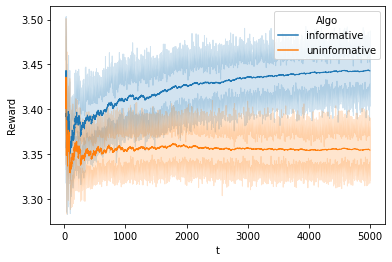

In [35]:
import seaborn as sns
result = pd.DataFrame({'rep':np.concatenate([np.ones(T)*rep for rep in range(S)]*2),
                       't':np.concatenate([range(T)]*2*S),
                       'Reward':np.concatenate(cum_reward_informative+cum_reward_uninformative),
                       'Algo':['informative']*T*S+['uninformative']*T*S})
sns.lineplot(data=result[result.t>20], x='t', y="Reward", hue="Algo", ci = 95,
             n_boot = 20, linewidth = 1.0, markers = False)